# ADV Example

The following example shows a simple workflow for analyzing ADV data using DOLfYN's tools. [DOLfYN]

A typical ADCP data workflow is broken down into
  1. Review the raw data
      - Check timestamps
      - Look at velocity data quality, particularly for spiking
  2. Check for spurious datapoints and remove. Replace bad datapoints using interpolation if desired
  3. Rotate the data into principal flow coordinates (streamwise, cross-stream, vertical)
  4. Average the data into bins, or ensembles, of a set time length (normally 5 to 10 min)
  5. Calculate turbulence statistics (turbulence intensity, TKE, Reynolds stresses) of the measured flowfield

Start by importing the necessary DOLfYN tools:

In [1]:
# Import core DOLfYN functions
import dolfyn as dlfn
# Import ADV-specific API tools
import dolfyn.adv.api as api

## Read Raw Instrument Data

DOLfYN currently only carries support for the Nortek Vector ADV. The example here loaded is simple 'tabletop' test data.

In [2]:
dat = dlfn.read_example('vector_data01.VEC') # use `dlfn.read([path to file + filename])` for your data
dat

Reading file c:\users\mcve343\dolfyn\dolfyn\example_data\vector_data01.VEC ...
 end of file at 3000000 bytes.


<xarray.Dataset>
Dimensions:              (time: 122912, dir: 3, beam: 3, x*: 3, earth: 3, inst: 3)
Coordinates:
  * time                 (time) float64 1.34e+09 1.34e+09 ... 1.34e+09 1.34e+09
  * dir                  (dir) <U1 'X' 'Y' 'Z'
  * beam                 (beam) int32 1 2 3
  * x*                   (x*) int32 1 2 3
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
Data variables:
    beam2inst_orientmat  (beam, x*) float64 2.709 -1.34 ... -0.3438 -0.3499
    c_sound              (time) float32 1.493e+03 1.493e+03 ... nan nan
    heading              (time) float32 5.6 10.5 10.51 10.52 ... nan nan nan nan
    pitch                (time) float32 -31.5 -31.7 -31.69 ... nan nan nan
    roll                 (time) float32 0.4 4.2 4.253 4.306 ... nan nan nan nan
    temp                 (time) float32 12.67 12.68 12.68 12.68 ... nan nan nan
    vel                  (dir, time) float32 -1.002 -1.008 -0.944 ... nan nan
    amp                  (dir, time) uint8 104 110 111 113 108 112 ... 0 0 0 0 0
    corr                 (dir, time) uint8 97 91 97 98 90 95 95 ... 0 0 0 0 0 0
    orientation_down     (time) bool True True True True ... True True True True
    pressure             (time) float64 5.448 5.436 5.484 5.448 ... 0.0 0.0 0.0
    orientmat            (earth, inst, time) float32 0.0832 0.155 ... -0.7065
Attributes:
    config:       {'ProLogID': 149, 'ProLogFWver': '4.08', 'config': 15412, '...
    inst_make:    Nortek
    inst_model:   Vector
    inst_type:    ADV
    rotate_vars:  ['vel']
    freq:         6000
    SerialNum:    VEC 9062
    Comments:     APL-UW vector on Tidal Turbulence Mooring in Admiralty, tim...
    fs:           32.0
    coord_sys:    inst
    has_imu:      0

The loaded dataset contains three primary groups of data. One: the velocity, amplitude, and correlation of the Doppler velocimetry; Two: measurements of the instrument's bearing and environment; and Three: the orientation matrices DOLfYN uses for rotating through coordinate frames.

## QC'ing Data

ADV velocity data tends to have spikes due to Doppler noise, and the common way to "despike" the data is by using the phase-space algorithm by Goring and Nikora (2002). DOLfYN integrates this function using a 2-step approach: create a logical mask where True corresponds to a spike detection, and then utilize an interpolation function to replace the spikes.

In [3]:
# Clean the file using the Goring+Nikora method:
mask = api.clean.GN2002(dat.vel, npt=5000)
# Replace bad datapoints via cubic spline interpolation
dat['vel'] = api.clean.clean_fill(dat['vel'], mask, npt=12, method='cubic')

print('Percent of data containing spikes: {0:.2f}%'.format(100*mask.mean()))

# If interpolation isn't desired:
dat_m = dat.copy(deep=True)
dat_m.coords['mask'] = (('dir','time'), ~mask)
dat_m['vel'] = dat_m.vel.where(dat_m.mask)

Percent of data containing spikes: 0.73%


## Coordinate Rotations

Now that the data has been cleaned, the next step is to rotate the velocity data into true East, North, Up coordinates

In [4]:
# First set the magnetic declination
dat_cln = dlfn.set_declination(dat, 10) # 10 degrees East

# Rotate that data from the instrument to earth frame:
dat_earth = dlfn.rotate2(dat_cln, 'earth')

Once in the true ENU frame of reference, we can calculate the principal flow direction for the velocity data and rotate it into principal coordinates (streamwise, cross-stream, vertical).

In [5]:
dat_earth.attrs['principal_heading'] = dlfn.calc_principal_heading(dat_earth.vel)
dat_fin = dlfn.rotate2(dat_earth, 'principal')

## Averaging Data

The next step in ADV analysis is to average the velocity data into time bins (ensembles). There are a couple ways to do this.

In [6]:
# Define an averaging object, create an 'ensembled' dataset and calculate basic turbulence statistics:
binner = api.ADVBinner(n_bin=9600, fs=dat_fin.fs, n_fft=4096, n_fft_coh=4096)
dat_binned = binner(dat_fin)

# Alternatively, the functional version of ADVBinner:
dat_binned = api.calc_turbulence(dat_fin, n_bin=9600, fs=dat_fin.fs, n_fft=4096)

The benefit to using `ADVBinner` is that one has access to all of the velocity and turbulence analysis functions that DOLfYN contains. If basic analysis will suffice, the `calc_turbulence` function is the most convienent. Either option can still utilize DOLfYN's shortcuts.

See the DOLfYN API in the documentation for the full list of functions and shortcuts.

In [7]:
# 'do' functions return a full dataset:
dat_binned = binner.do_var(dat_fin, out_ds=dat_binned) # calculate the variance of each binned variable and add it to the averaged dataset

# 'calc' functions return a dataArray:
dat_binned['cross-spec'] = binner.calc_vel_csd(dat_fin['vel'], freq_units='rad/s')

# 'shortcuts' are accessed through the keyword 'Veldata' and can easily be added to the dataset
dat_binned['TI'] = dat_binned.Veldata.I

Text(0.5, 1.0, 'Streamwise Direction')

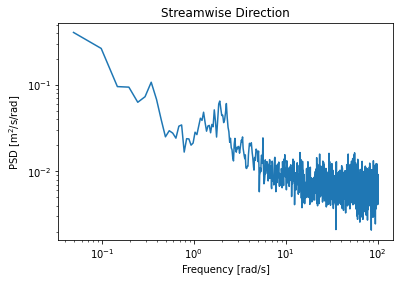

In [18]:
# Plot spectra
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.loglog(dat_binned.omega, dat_binned.spec.sel(Sxx='Suu').mean(axis=0))
plt.xlabel('Frequency [rad/s]')
plt.ylabel('PSD $\mathrm{[m^2/s/rad]}$')
plt.title('Streamwise Direction')